# Tuning hyperparameters of lightGBM using Bayesian optimization

In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")

import myFunc as mf



tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



As the skippimg behavior might change from day to day, the model is trained on the data a day ahead (Sep 17, 2018)

In [3]:
file_list = []
for logN in range(10):
    file_list.append('../data/raw/training_set/log_'+str(logN)+'_20180917_000000000000.csv')

file_list

['../data/raw/training_set/log_0_20180917_000000000000.csv',
 '../data/raw/training_set/log_1_20180917_000000000000.csv',
 '../data/raw/training_set/log_2_20180917_000000000000.csv',
 '../data/raw/training_set/log_3_20180917_000000000000.csv',
 '../data/raw/training_set/log_4_20180917_000000000000.csv',
 '../data/raw/training_set/log_5_20180917_000000000000.csv',
 '../data/raw/training_set/log_6_20180917_000000000000.csv',
 '../data/raw/training_set/log_7_20180917_000000000000.csv',
 '../data/raw/training_set/log_8_20180917_000000000000.csv',
 '../data/raw/training_set/log_9_20180917_000000000000.csv']

In [4]:
# import random
# random.Random(23).shuffle(file_list) # randomly shuffle the list
# file_list

The function mf.prep_dfs contains a few important steps of data preprocessing and data augmentation.


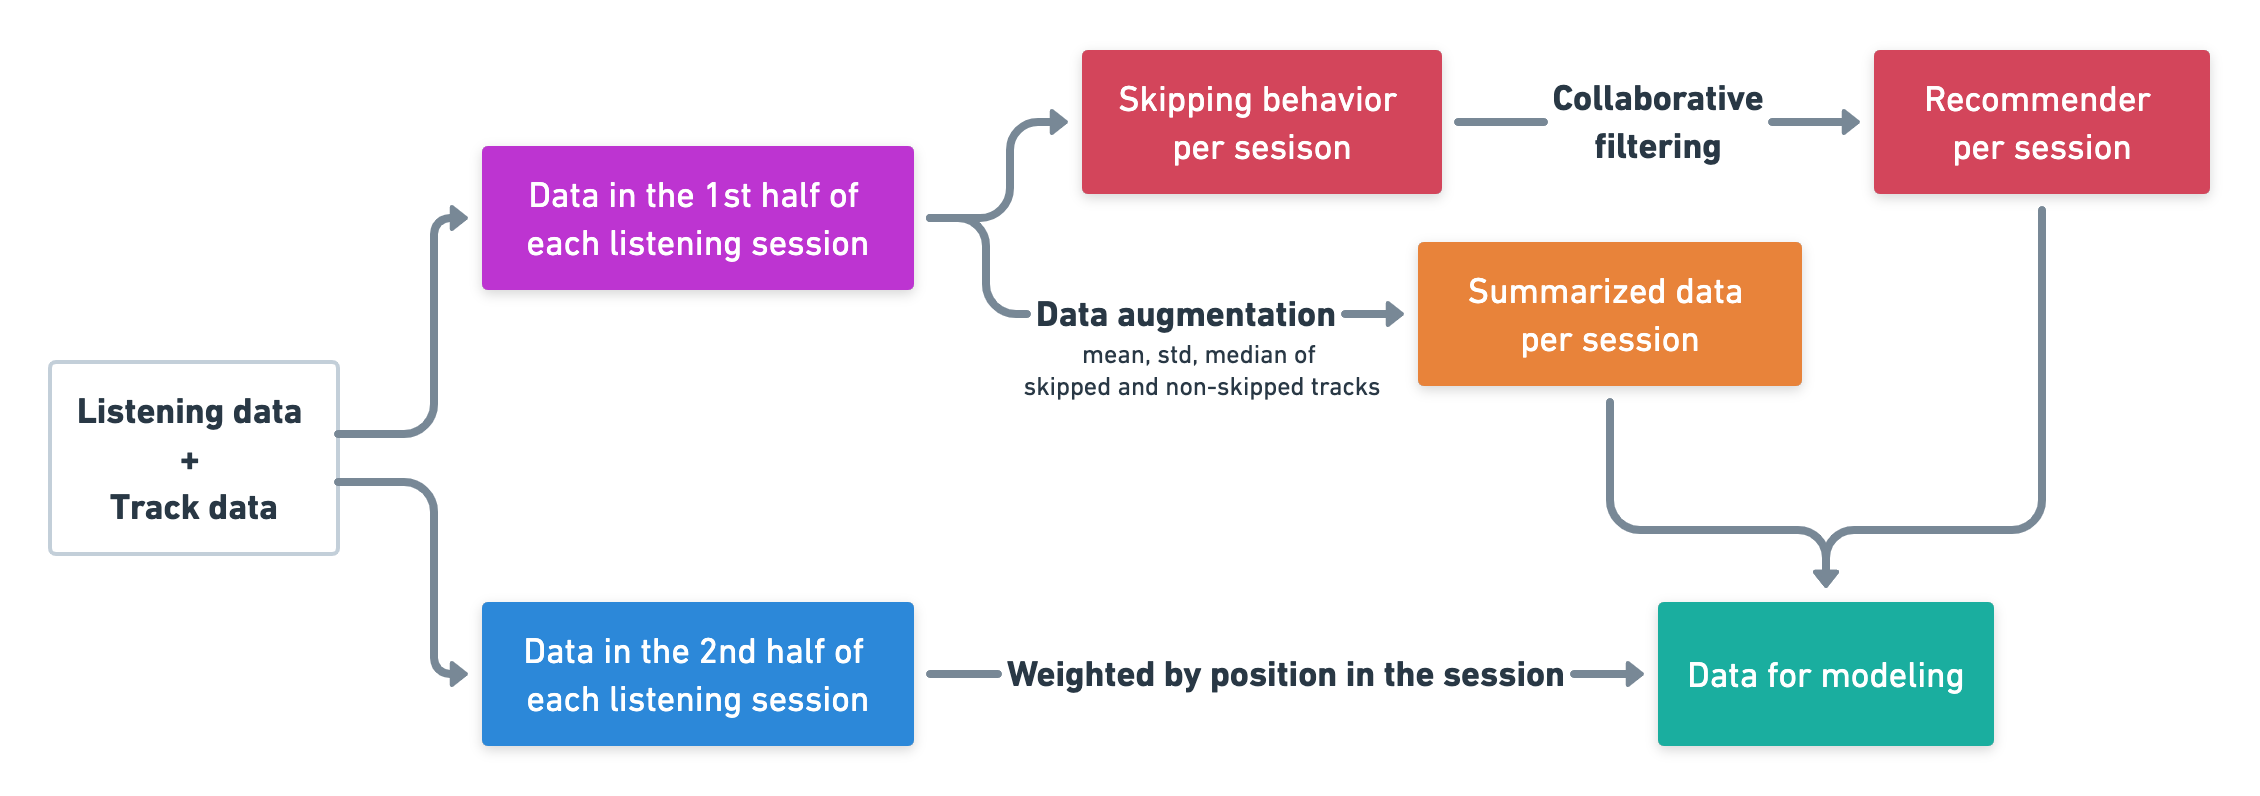

In [7]:
from timeit import default_timer as timer #to see how long the computation will take

nFile = 0
batch_size = 10
while nFile < 50:
    start = timer()
    nFile += batch_size
    df_lookup_list = []
    for file in file_list[(nFile-batch_size):min(nFile, len(file_list))]:
        df_lookup_list.append(mf.prep_dfs(file, tf_df, kmean300_df))

    df_lookup = pd.concat(df_lookup_list)
    df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))

    dtrain = lgb.Dataset(df_lookup.drop(columns = ['session_id','track_id_clean','skip_2','weight']).astype('float32'), 
                         label=df_lookup['skip_2'],
                         weight = df_lookup['weight'],
                         free_raw_data=False) # https://lightgbm.readthedocs.io/en/latest/FAQ.html#error-messages-cannot-before-construct-dataset

    def bo_tune_lgb(num_leaves, learning_rate, num_iterations, bagging_fraction, bagging_freq, feature_fraction, min_gain_to_split, nFile, batch_size):
        params = {'num_leaves': int(num_leaves),
                  'learning_rate':learning_rate,
                  'metric': 'binary_error',
                  'num_iterations':int(num_iterations),
                  'bagging_fraction':bagging_fraction,
                  'bagging_freq':int(bagging_freq),
                  'feature_fraction':feature_fraction,
                  'min_gain_to_split':min_gain_to_split,
                  'objective': 'binary',
                  'force_row_wise': True,
                  'num_threads': 5,
                  'verbosity': 0,
                  'tree_learner': 'voting_parallel'} #https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html


        cv_result = lgb.cv(params, dtrain, nfold=4, return_cvbooster=True)
            
        cv_result['cvbooster'].save_model('../models/SVD/LightGBM_BayesOpt_dec17/for20180918/cvbooster_5tracks_'+str(int(nFile))+'_dec23.txt')
        return 1-cv_result['binary_error-mean'][-1]

    lgb_bo = BayesianOptimization(bo_tune_lgb,
                                  pbounds={'num_leaves': (2, 30),
                                           'learning_rate':(0.01,0.2),
                                           'num_iterations': (500,1000),
                                           'bagging_fraction': (0.75,1),
                                           'bagging_freq': (1,4),
                                           'feature_fraction': (0.6, 0.8),
                                           'min_gain_to_split':(0,0.4),
                                           'nFile': (nFile,nFile), 
                                           'batch_size': (batch_size,batch_size)
                                            },
                                  random_state=23
                                 )

    logger = JSONLogger(path='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/logs_shuffle10.json')
    lgb_bo.subscribe(Events.OPTIMIZATION_STEP, logger)

    start = timer()
    lgb_bo.maximize(n_iter=25, init_points=10)
    print('Runtime: %0.2fs' % (timer() - start))

ValueError: No objects to concatenate